In [1]:
from experiment import Experiment
import torch
torch.manual_seed(2)
%matplotlib inline

In [2]:
var_dict = dict(
    categorical_vars = ['Work_accident', 'promotion_last_5years', 'sales', 
                        'salary', 'number_project','time_spend_company'],
    numerical_vars = ['satisfaction_level', 'last_evaluation', 'average_montly_hours'],
    class_var = 'left'
)

In [3]:
exp = Experiment('data/HR_comma_sep.csv', 
                 var_dict,
                 embedding_dim=4,
                 lr=0.001,
                 batch_size=1024,
                 weight_decay=0.001,
                 n_epoch=100,
                 verbose=True,
                 n_bins_range=[10,15],#range(15, 16),
                 n_init_bins_list=[15])

In [4]:
print('#Numerical Vars =', len(var_dict['numerical_vars']))
print('#Categorical Vars =', len(var_dict['categorical_vars']))
print('#Dummy coded categorical cols =', exp.n_dummy_coded_categorical_cols)

#Numerical Vars = 3
#Categorical Vars = 6
#Dummy coded categorical cols = 17


In [5]:
%time clf_scores = exp.test_classification_performance(cv=3)

>>> Epoch = 1, Loss = 0.651894211769104
[13, 11, 11]
>>> Epoch = 2, Loss = 0.5973675847053528
[13, 11, 11]
>>> Epoch = 3, Loss = 0.5487809181213379
[13, 11, 14]
>>> Epoch = 4, Loss = 0.506130576133728
[15, 11, 7]
>>> Epoch = 5, Loss = 0.4612899422645569


KeyboardInterrupt: 

In [6]:
exp.print_classification_scores(clf_scores, method='dummy_only')

DT performance
#cols = 34.0, Accuracy = 0.959 (+/- 0.003)
LR performance
#cols = 34.0, Accuracy = 0.896 (+/- 0.008)


In [7]:
exp.print_classification_scores(clf_scores, method='scale_numeric')

DT performance
#cols = 34.0, Accuracy = 0.959 (+/- 0.003)
LR performance
#cols = 34.0, Accuracy = 0.896 (+/- 0.008)


In [8]:
exp.print_classification_scores(clf_scores, method='equal_width')

DT performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.929 (+/- 0.006)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.941 (+/- 0.012)
LR performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.942 (+/- 0.001)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.953 (+/- 0.003)
NB performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.920 (+/- 0.005)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.926 (+/- 0.008)


In [9]:
exp.print_classification_scores(clf_scores, method='equal_freq')

DT performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.931 (+/- 0.007)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.936 (+/- 0.007)
LR performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.937 (+/- 0.006)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.948 (+/- 0.003)
NB performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.906 (+/- 0.008)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.918 (+/- 0.006)


In [10]:
exp.print_classification_scores(clf_scores, method='semantic_binning')

DT performance
#Init Bins = 15, #Avg Cols = 55.333333333333336, Accuracy = 0.947 (+/- 0.016)
LR performance
#Init Bins = 15, #Avg Cols = 55.333333333333336, Accuracy = 0.936 (+/- 0.013)
NB performance
#Init Bins = 15, #Avg Cols = 55.333333333333336, Accuracy = 0.902 (+/- 0.019)


In [11]:
exp.semantic_binning.bins_by_var

{'average_montly_hours': {'bins': ['(95.999, 133.0]',
   '(133.0, 142.0]',
   '(142.0, 168.0]',
   '(168.0, 180.0]',
   '(180.0, 192.0]',
   '(192.0, 206.0]',
   '(206.0, 220.0]',
   '(220.0, 231.0]',
   '(231.0, 243.0]',
   '(243.0, 252.0]',
   '(252.0, 262.0]',
   '(262.0, 272.0]',
   '(272.0, 310.0]'],
  'split_point': [95.999,
   133.0,
   142.0,
   168.0,
   180.0,
   192.0,
   206.0,
   220.0,
   231.0,
   243.0,
   252.0,
   262.0,
   272.0,
   310.0]},
 'last_evaluation': {'bins': ['(0.359, 0.7]',
   '(0.7, 0.74]',
   '(0.74, 0.97]',
   '(0.97, 1.0]'],
  'split_point': [0.359, 0.7, 0.74, 0.97, 1.0]},
 'satisfaction_level': {'bins': ['(0.089, 0.14]',
   '(0.14, 0.31]',
   '(0.31, 0.72]',
   '(0.72, 0.76]',
   '(0.76, 0.94]',
   '(0.94, 1.0]'],
  'split_point': [0.089, 0.14, 0.31, 0.72, 0.76, 0.94, 1.0]}}

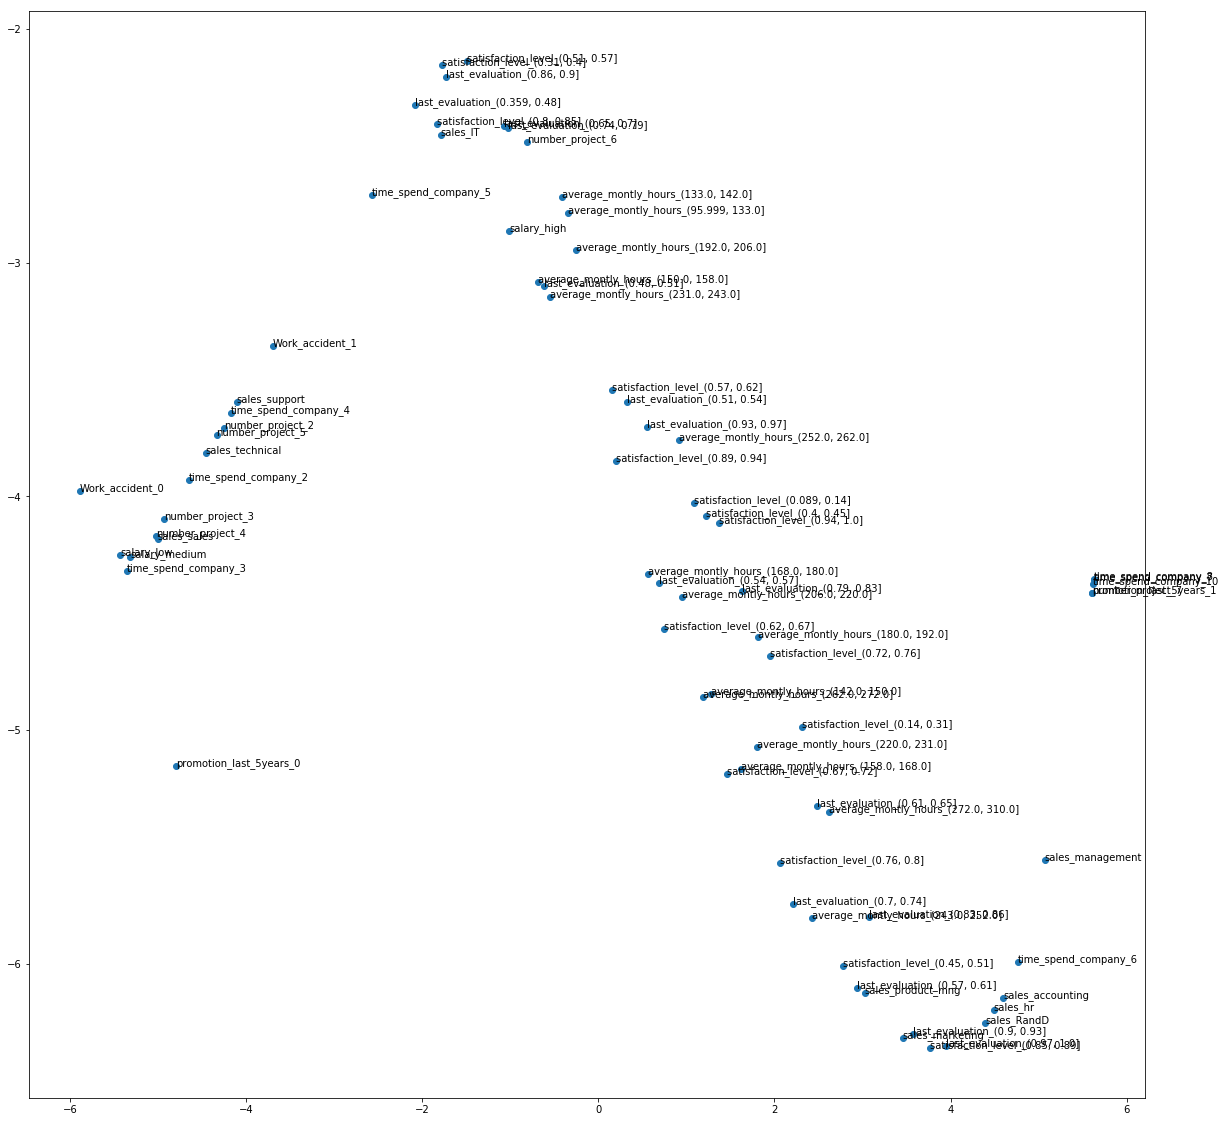

In [12]:
exp.semantic_binning.visualize_bin_embeddings()

### 학습된 트리의 깊이, 형태 비교

In [13]:
# dot_data = StringIO()
# export_graphviz(dt, out_file=dot_data, feature_names=X.columns, 
#                 impurity=False, proportion=True)
# graph = pydot.graph_from_dot_data(dot_data.getvalue())

In [35]:
exp = Experiment('data/HR_comma_sep.csv', 
                 var_dict,
                 embedding_dim=8,
                 lr=0.001,
                 batch_size=1024,
                 n_epoch=70,
                 verbose=True,
                 n_bins_range=[10,15],#range(15, 16),
                 n_init_bins_list=[15])

In [75]:
% time exp.semantic_binning.fit(exp.data, n_init_bins=30)

>>> Epoch = 1, Loss = 0.6128760576248169
>>> Epoch = 2, Loss = 0.4678899943828583
>>> Epoch = 3, Loss = 0.32869502902030945
>>> Epoch = 4, Loss = 0.26530396938323975
>>> Epoch = 5, Loss = 0.22731715440750122
>>> Epoch = 6, Loss = 0.21010524034500122
>>> Epoch = 7, Loss = 0.1976725310087204
>>> Epoch = 8, Loss = 0.1931028962135315
>>> Epoch = 9, Loss = 0.18780821561813354
>>> Epoch = 10, Loss = 0.1846350133419037
>>> Epoch = 11, Loss = 0.18508388102054596
>>> Epoch = 12, Loss = 0.18336611986160278
>>> Epoch = 13, Loss = 0.1826234757900238
>>> Epoch = 14, Loss = 0.18195417523384094


KeyboardInterrupt: 

In [71]:
for var in exp.var_dict['numerical_vars']:
    print(var)

satisfaction_level
last_evaluation
average_montly_hours


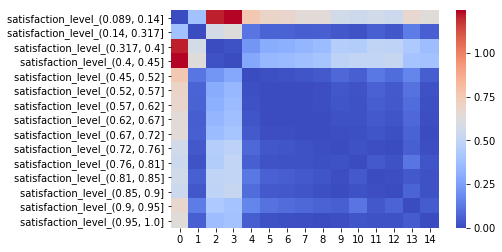

In [85]:
exp.semantic_binning.plot_pairwise_distance_between_bins('satisfaction_level')

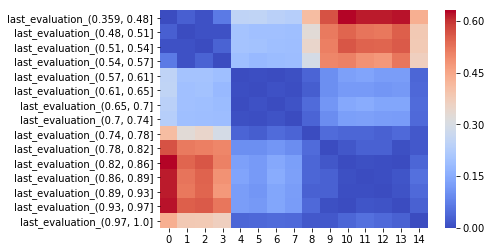

In [86]:
exp.semantic_binning.plot_pairwise_distance_between_bins('last_evaluation')

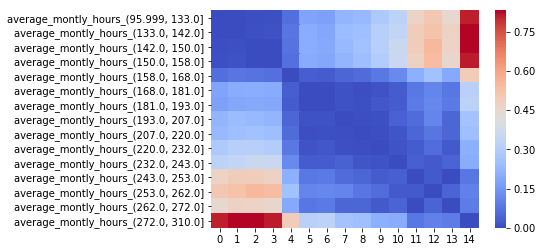

In [87]:
exp.semantic_binning.plot_pairwise_distance_between_bins('average_montly_hours')

In [41]:
for var, bins in exp.semantic_binning.bins_by_var.items():
    print(var)
    print(bins['bins'])

satisfaction_level
['(0.089, 0.14]', '(0.14, 0.317]', '(0.317, 0.45]', '(0.45, 1.0]']
last_evaluation
['(0.359, 0.57]', '(0.57, 0.74]', '(0.74, 0.78]', '(0.78, 0.97]', '(0.97, 1.0]']
average_montly_hours
['(95.999, 158.0]', '(158.0, 243.0]', '(243.0, 310.0]']


In [321]:
def find_nn(query, embedding_by_column, k=30, exclude_self=False):
    embedding_of_query = embedding_by_column[query]
    distances = dict()
    for col, embedding in embedding_by_column.items():
        distances[col] = np.linalg.norm(embedding - embedding_of_query)
    knn = sorted(distances.items(), key=lambda x: x[1])
    if exclude_self:
        knn = knn[1:]
    return knn[:k]

temp_cols = sorted([x for x in find_nn('average_montly_hours_(95.999, 133.0]', temp, k=100)
        if 'average_montly' in x[0]], key=lambda x: float(x[0].split('_')[-1].split(', ')[0][1:]))

### Convergence check

### Tracking #Cluster 

In [4]:
from data_handler import DataHandler

In [5]:
handler = DataHandler(exp.data, exp.var_dict)

In [6]:
from semantic_binning import SemanticBinning

In [7]:
sb = SemanticBinning(handler.var_dict,embedding_dim=8,batch_size=1024,n_epoch=100,lr=0.01,
                     weight_decay=0,verbose=True)

In [8]:
sb.fit(exp.data, n_init_bins=30)

>>> Epoch = 1, Loss = 0.18291133642196655
[28, 13, 12]
>>> Epoch = 2, Loss = 0.17932730913162231
[28, 17, 29]
>>> Epoch = 3, Loss = 0.18045024573802948
[26, 17, 27]
>>> Epoch = 4, Loss = 0.17932505905628204
[16, 22, 25]
>>> Epoch = 5, Loss = 0.17805224657058716
[15, 12, 24]
>>> Epoch = 6, Loss = 0.1761971414089203
[25, 12, 20]
>>> Epoch = 7, Loss = 0.17683053016662598
[22, 12, 14]
>>> Epoch = 8, Loss = 0.1774381548166275
[8, 10, 10]
>>> Epoch = 9, Loss = 0.17626087367534637
[6, 10, 10]
>>> Epoch = 10, Loss = 0.17529530823230743
[4, 19, 10]
>>> Epoch = 11, Loss = 0.17496736347675323
[4, 8, 7]
>>> Epoch = 12, Loss = 0.17398297786712646
[4, 8, 5]
>>> Epoch = 13, Loss = 0.17470239102840424
[4, 3, 12]
>>> Epoch = 14, Loss = 0.17347490787506104
[4, 3, 3]
>>> Epoch = 15, Loss = 0.17405956983566284
[4, 6, 3]
>>> Epoch = 16, Loss = 0.174397811293602
[4, 6, 3]
>>> Epoch = 17, Loss = 0.17380449175834656
[4, 2, 3]
>>> Epoch = 18, Loss = 0.1726873219013214
[4, 2, 3]
>>> Epoch = 19, Loss = 0.1744948

In [9]:
sb.bins_by_var['satisfaction_level']['bins']

['(0.089, 0.21]', '(0.21, 0.317]', '(0.317, 0.45]', '(0.45, 1.0]']

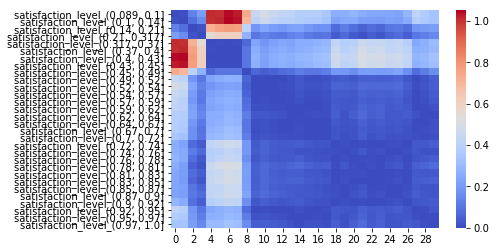

In [10]:
sb.plot_pairwise_distance_between_bins('satisfaction_level')

In [9]:
sb.bins_by_var['satisfaction_level']['bins']

['(0.089, 0.21]', '(0.21, 0.317]', '(0.317, 0.45]', '(0.45, 1.0]']

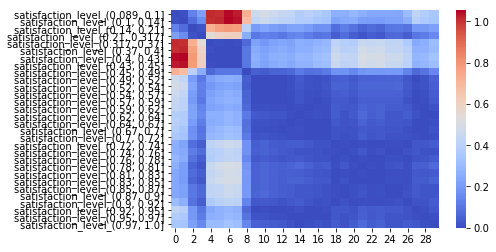

In [10]:
sb.plot_pairwise_distance_between_bins('satisfaction_level')

In [11]:
sb.bins_by_var['last_evaluation']['bins']

['(0.359, 0.57]', '(0.57, 0.76]', '(0.76, 1.0]']

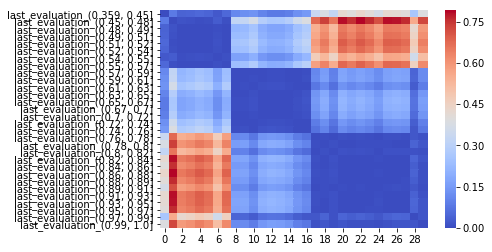

In [12]:
sb.plot_pairwise_distance_between_bins('last_evaluation')

In [11]:
sb.bins_by_var['last_evaluation']['bins']

['(0.359, 0.57]',
 '(0.57, 0.76]',
 '(0.76, 0.97]',
 '(0.97, 0.99]',
 '(0.99, 1.0]']

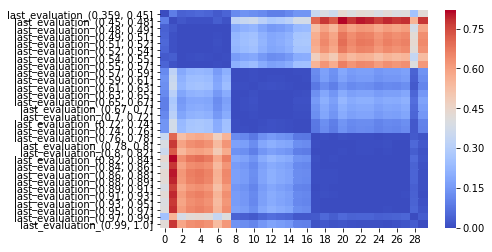

In [12]:
sb.plot_pairwise_distance_between_bins('last_evaluation')

In [13]:
sb.bins_by_var['average_montly_hours']['bins']

['(95.999, 126.0]',
 '(126.0, 162.0]',
 '(162.0, 214.0]',
 '(214.0, 243.0]',
 '(243.0, 282.0]',
 '(282.0, 310.0]']

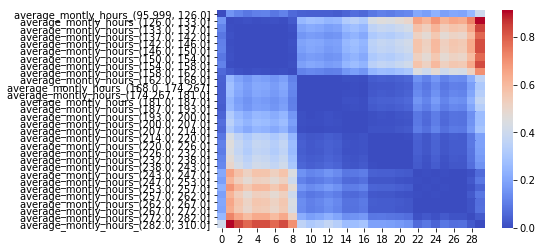

In [14]:
sb.plot_pairwise_distance_between_bins('average_montly_hours')

In [13]:
sb.bins_by_var['average_montly_hours']['bins']

['(95.999, 126.0]',
 '(126.0, 162.0]',
 '(162.0, 214.0]',
 '(214.0, 243.0]',
 '(243.0, 282.0]',
 '(282.0, 310.0]']

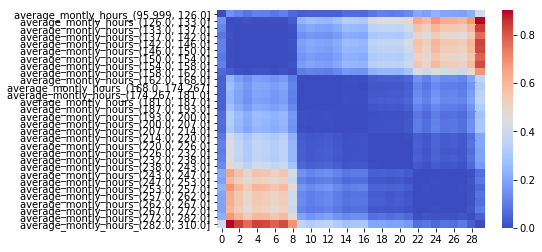

In [14]:
sb.plot_pairwise_distance_between_bins('average_montly_hours')